<a href="https://colab.research.google.com/github/smomtahe/Project_BreastCancer_Advanced_DeepLearnig/blob/main/1_DL_VAE_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
dataset_df=pd.read_csv("/content/dataValues.csv")

# Splitting the dataset into features (X) and targets (Y)
X = dataset_df.iloc[:, :128].values
Y = dataset_df.iloc[:, 128:].values


# Manually split the dataset into training and testing sets according to my  criteria

X_train = X[20:]  # First 120 for training
Y_train = Y[20:]

X_test = X[:20]  # Last 20 for testing
Y_test = Y[:20]

#X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Simple NN Model
input_shape = (128,)  # Shape of the features
base_model_input = Input(shape=input_shape)
x = Dense(256, activation='relu')(base_model_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
base_model_output = Dense(128, activation='relu')(x)  # Intermediate output

# Now, create the new model
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(base_model_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
final_output = Dense(128)(x)  # Output layer for your targets

# Define the full model
model = Model(inputs=base_model_input, outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_36 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_18 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dense_38 (Dense)            (None, 512)               66048     
                                                             

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/100
6/6 [==============================] - 3s 87ms/step - loss: 3.5389 - mae: 1.3547 - val_loss: 0.6884 - val_mae: 0.2743
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 2.9728 - mae: 1.2397 - val_loss: 0.6826 - val_mae: 0.2722
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 2.6188 - mae: 1.1279 - val_loss: 0.6773 - val_mae: 0.2702
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 2.4314 - mae: 1.0775 - val_loss: 0.6724 - val_mae: 0.2689
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 2.2158 - mae: 1.0212 - val_loss: 0.6679 - val_mae: 0.2685
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 2.0488 - mae: 0.9643 - val_loss: 0.6637 - val_mae: 0.2682
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 1.8243 - mae: 0.9035 - val_loss: 0.6595 - val_mae: 0.2678
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 1.7849 - mae: 0.86

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_shape=(128,), latent_dim=32):
    # Encoder
    encoder_inputs = Input(shape=input_shape)
    x = layers.Dense(64, activation='relu')(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(64, activation='relu')(latent_inputs)
    decoder_outputs = layers.Dense(input_shape[0], activation='sigmoid')(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    # VAE Model
    outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, outputs, name='vae')

    # Add VAE loss
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    return vae

# Example usage:
vae = build_vae()
vae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))


Epoch 1/100
4/4 [==============================] - 2s 114ms/step - loss: 0.2424 - val_loss: 0.2267
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.2077 - val_loss: 0.1969
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1831 - val_loss: 0.1818
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1683 - val_loss: 0.1692
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1552 - val_loss: 0.1570
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 0.1412 - val_loss: 0.1467
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1323 - val_loss: 0.1308
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1208 - val_loss: 0.1210
Epoch 9/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1125 - val_loss: 0.1104
Epoch 10/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1033 - val_loss: 0.0980
Epoch 11/100
4/4 [

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1/1 [==============================] - 0s 26ms/step - loss: 0.3870 - mae: 0.2226
Test Loss: 0.38701605796813965, Test MAE: 0.22258083522319794


In [ ]:
predictions = vae.predict(X_test)

print(f"[{', '.join(map(str, 1/predictions[2]))}]")

1/1 [==============================] - 0s 21ms/step
[2.5319407, 5.1350737, 5.295965, 3.9033263, 7.7776546, 6.154783, 5.776375, 4.3502812, 3.9994602, 7.4895587, 7.064953, 7.716606, 5.0054035, 5.320422, 9.583764, 11.301178, 5.6001525, 11.033556, 4.5014043, 22.462782, 9.341695, 18.468697, 10.157227, 8.688582, 15.798977, 20.605381, 27.226063, 13.855012, 16.280117, 22.554123, 18.143911, 49.975163, 17.985422, 29.007092, 8.830186, 48.39789, 19.456133, 53.971146, 14.226217, 90.38035, 55.282593, 32.809723, 35.493958, 39.596615, 34.37992, 19.26839, 52.985703, 19.42749, 26.591528, 57.18197, 62.180744, 40.12349, 26.682713, 84.9541, 11.18749, 43.105873, 26.50287, 49.895638, 39.54983, 29.187452, 50.818844, 27.398537, 50.443367, 39.566906, 23.33893, 31.628483, 17.637676, 51.731297, 9.851349, 13.465693, 19.734282, 50.679184, 26.507793, 36.036816, 19.91236, 20.337904, 32.61015, 37.95989, 39.143677, 11.920285, 44.149162, 32.25925, 37.2825, 32.11032, 29.263742, 21.103125, 29.244413, 13.186378, 18.676424,

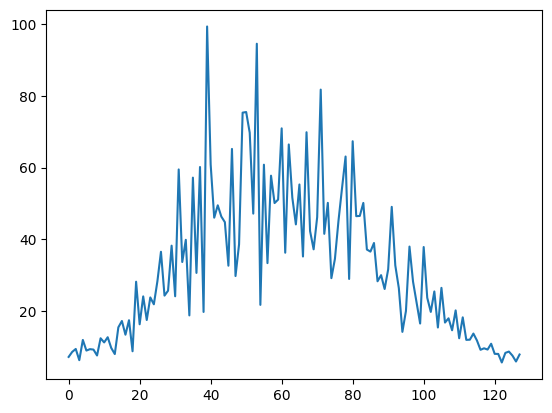

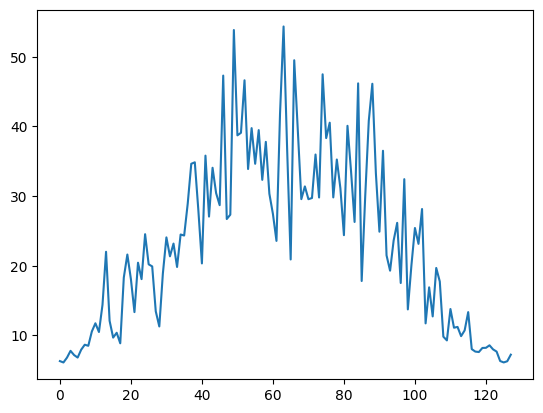

In [ ]:
import matplotlib.pyplot as plt
plt.plot(1/predictions[2]+1/predictions[3])
plt.show()
import matplotlib.pyplot as plt
plt.plot(1/predictions[4]+1/predictions[5])
plt.show()


In [ ]:
#GAN # generate more data
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
# Adjusted optimizer import for legacy support
from tensorflow.keras.optimizers import Adam

# Load dataset
dataset_df = pd.read_csv("https://raw.githubusercontent.com/smomtahe/Imaging/main/dataValues.csv")

# Splitting the dataset into features (X) and targets (Y)
X = dataset_df.iloc[:, :128].values
Y = dataset_df.iloc[:, 128:].values

X_train = X[20:]  # Use part of the data for training
Y_train = Y[20:]
X_test = X[:20]  # Use part of the data for testing
Y_test = Y[:20]

def build_generator():
    model = Sequential([
        Dense(256, input_dim=100),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(1024),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(128, activation='tanh')
    ])
    return model

def build_discriminator():
    model = Sequential([
        Dense(512, input_dim=128),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
generator = build_generator()

# The GAN model stacks the generator and discriminator
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

def train(gan, generator, discriminator, epochs, batch_size):
    for epoch in range(epochs):

        #  Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #  Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Plot the progress
        print(f"Epoch: {epoch+1}/{epochs}, D loss: {d_loss[0]}, G loss: {g_loss}")

# Adjust epochs and batch_size for quicker training
epochs = 1000  # Reduced number of epochs
batch_size = 16  # Reduced batch size for quicker iterations

train(gan, generator, discriminator, epochs, batch_size)


1/1 [==============================] - 0s 106ms/step


Epoch: 1/1000, D loss: 0.6845583617687225, G loss: 0.7154369354248047
1/1 [==============================] - 0s 21ms/step
Epoch: 2/1000, D loss: 0.6586195528507233, G loss: 0.728855311870575
1/1 [==============================] - 0s 20ms/step
Epoch: 3/1000, D loss: 0.6042611002922058, G loss: 0.8001248836517334
1/1 [==============================] - 0s 20ms/step
Epoch: 4/1000, D loss: 0.6039732992649078, G loss: 0.8060431480407715
1/1 [==============================] - 0s 21ms/step
Epoch: 5/1000, D loss: 0.5464248955249786, G loss: 0.8868727087974548
1/1 [==============================] - 0s 22ms/step
Epoch: 6/1000, D loss: 0.5273275971412659, G loss: 0.9669351577758789
1/1 [==============================] - 0s 22ms/step
Epoch: 7/1000, D loss: 0.5020945072174072, G loss: 1.0279468297958374
1/1 [==============================] - 0s 21ms/step
Epoch: 8/1000, D loss: 0.47945964336395264, G loss: 1.131148099899292
1/1 [==============================] - 0s 20ms/step
Epoch: 9/1000, D loss: 0.

In [ ]:
# The 'generator' is already trained
noise_dim = 100  # Dimension of the random noise vector

# Generate random noise for two samples
random_noise = np.random.normal(0, 1, (2, noise_dim))

# Use the generator to generate two new data points from the random noise
generated_samples = generator.predict(random_noise)

# Display the generated samples
print("Generated Sample 1:", generated_samples[0])
print("Generated Sample 2:", generated_samples[1])

import matplotlib.pyplot as plt
plt.plot(generated_samples[0])
plt.show()
import matplotlib.pyplot as plt
plt.plot(generated_samples[1])
plt.show()

1/1 [==============================] - 0s 33ms/step
Generated Sample 1: [ 0.70350635  0.9815174   0.9961451   0.88238764  0.7324543   0.93950784
  0.7248088   0.71501607  0.13873464  0.6971237   0.63351333  0.45061234
  0.30998564  0.7472957   0.61521554  0.7191789   0.598045    0.34719807
  0.2806898   0.3454375   0.4271923   0.7256524   0.5067796   0.11112344
  0.46511453 -0.26063156  0.4129605   0.5815971   0.53473365  0.3922429
  0.2400457   0.7757486   0.43091103  0.5454803   0.49006975  0.13435175
  0.34605315  0.24393065  0.53235245 -0.25523603  0.52256906 -0.10035128
  0.15203412  0.37949738  0.04526922  0.49658838  0.2417466   0.6943819
  0.1567082  -0.05897225  0.08355054 -0.14714779  0.21962576  0.3993984
  0.01020194  0.32061478  0.15797985  0.64987737  0.11779088 -0.04407121
  0.06048779  0.3056091  -0.05466193 -0.04691653 -0.19197121  0.5723772
  0.07463111 -0.00230362  0.36993966  0.6207844   0.17867094  0.24808243
  0.07596341 -0.12631516  0.28768444  0.17701903  0.3474

In [ ]:
# Transfer Learning  (Value -> Value)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Load dataset
dataset_df = pd.read_csv("https://raw.githubusercontent.com/smomtahe/Imaging/main/dataValues.csv")

# Splitting the dataset into features (X) and targets (Y)
X = dataset_df.iloc[:, :128].values
Y = dataset_df.iloc[:, 128:].values

# Splitting the dataset for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.14, random_state=42)

# Simulated "Pre-trained" Base Model (feature extractor)
def build_base_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    model = Model(inputs, x)
    return model

# Custom Model Built on Top of the Base Model
def build_custom_model(base_model):
    x = base_model.output
    x = Dense(64, activation='relu')(x)
    outputs = Dense(128, activation='linear')(x)  # Output layer for regression
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Building and compiling the model
base_model = build_base_model((128,))
custom_model = build_custom_model(base_model)
custom_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Training the model
custom_model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Making predictions with the model
predictions = custom_model.predict(X_test[:2])

# Displaying predictions for X_test[0] and X_test[1]
print("Predictions for X_test[0]:", predictions[0])
print("Predictions for X_test[1]:", predictions[1])

Epoch 1/100
3/3 - 1s - loss: 0.3496 - mae: 0.4630 - val_loss: 0.0730 - val_mae: 0.1468 - 1s/epoch - 447ms/step
Epoch 2/100
3/3 - 0s - loss: 0.2191 - mae: 0.3623 - val_loss: 0.0720 - val_mae: 0.1414 - 42ms/epoch - 14ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1725 - mae: 0.3158 - val_loss: 0.0715 - val_mae: 0.1401 - 38ms/epoch - 13ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1519 - mae: 0.2932 - val_loss: 0.0709 - val_mae: 0.1385 - 45ms/epoch - 15ms/step
Epoch 5/100
3/3 - 0s - loss: 0.1373 - mae: 0.2698 - val_loss: 0.0702 - val_mae: 0.1371 - 56ms/epoch - 19ms/step
Epoch 6/100
3/3 - 0s - loss: 0.1280 - mae: 0.2562 - val_loss: 0.0695 - val_mae: 0.1360 - 36ms/epoch - 12ms/step
Epoch 7/100
3/3 - 0s - loss: 0.1216 - mae: 0.2438 - val_loss: 0.0688 - val_mae: 0.1351 - 36ms/epoch - 12ms/step
Epoch 8/100
3/3 - 0s - loss: 0.1161 - mae: 0.2385 - val_loss: 0.0681 - val_mae: 0.1349 - 36ms/epoch - 12ms/step
Epoch 9/100
3/3 - 0s - loss: 0.1090 - mae: 0.2243 - val_loss: 0.0675 - val_mae: 0.1348 - 41ms/epoch - 14m

1/1 [==============================] - 0s 97ms/step
Mean Squared Error (MSE) on Test Set: 0.07003607600927353
Mean Absolute Error (MAE) on Test Set: 0.1917978972196579
Pseudo-Accuracy (within 10% of actual): 1.64%
a=[0.08011807, 0.079426505, 0.0749111, 0.08909332, 0.06894935, 0.058173377, 0.081053324, 0.0780539, 0.08916209, 0.06483937, 0.08057133, 0.08048277, 0.06397296, 0.087639764, 0.069680475, 0.067458406, 0.08330677, 0.09046319, 0.085386954, 0.06450282, 0.07861712, 0.07532958, 0.07620729, 0.07847398, 0.07632843, 0.08915242, 0.07232007, 0.09387596, 0.100142844, 0.079550855, 0.07523971, 0.08304574, 0.089159906, 0.079552606, 0.09840209, 0.100113615, 0.094284706, 0.090544514, 0.08111295, 0.0883076, 0.075472064, 0.098764986, 0.08777469, 0.075232804, 0.09515181, 0.09406274, 0.090182334, 0.11013917, 0.08219023, 0.107639864, 0.09398297, 0.09348911, 0.10993761, 0.09286971, 0.10753547, 0.10710757, 0.0668798, 0.09191053, 0.083724365, 0.09952599, 0.093765154, 0.09707321, 0.10479961, 0.09854985

<ipython-input-158-5867dc576051>:18: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true) <= percentage)


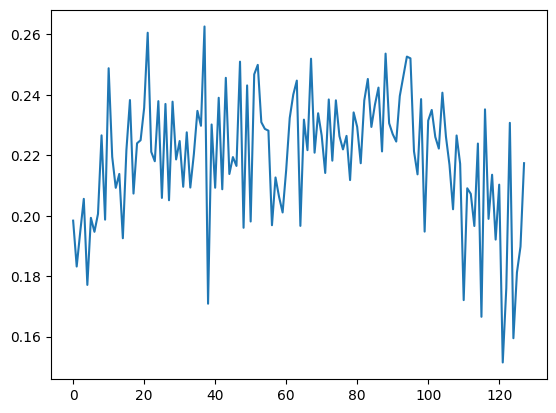

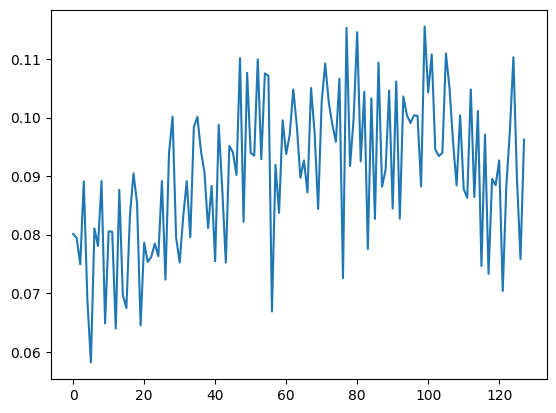

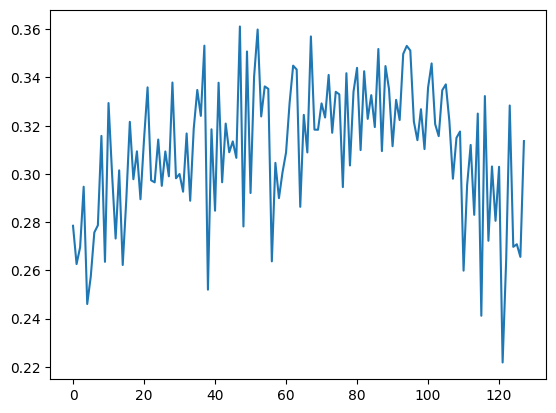

In [ ]:
# Evaluate the model
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
mse = MeanSquaredError()
mae = MeanAbsoluteError()

# Predictions on the test set
predictions = custom_model.predict(X_test)

# Calculate MSE and MAE
mse.update_state(Y_test, predictions)
mae.update_state(Y_test, predictions)

print(f"Mean Squared Error (MSE) on Test Set: {mse.result().numpy()}")
print(f"Mean Absolute Error (MAE) on Test Set: {mae.result().numpy()}")

print(f"a=[{', '.join(map(str, predictions[4]))}];")
print(f"aa=[{', '.join(map(str, predictions[5]))}];")

import matplotlib.pyplot as plt
plt.plot(predictions[0])
plt.show()
import matplotlib.pyplot as plt
plt.plot(predictions[1])
plt.show()
import matplotlib.pyplot as plt
plt.plot(predictions[0]+predictions[1])
plt.show()


In [ ]:
# Save the custom_model as an h5 file and its weights
custom_model.save('custom_model.h5')  # Saves the model architecture and weights
custom_model.save_weights('custom_model_weights.h5')  # Saves just the weights

# To load the model and weights back
from tensorflow.keras.models import load_model

# Loading the model back
loaded_model = load_model('custom_model.h5')


# I can use loaded_model.load_weights('custom_model_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
